<a href="https://colab.research.google.com/github/Pappas313/Computational-vision/blob/main/%CE%A5%CF%80%CE%BF%CE%BB%CE%BF%CE%B3%CE%B9%CF%83%CF%84%CE%B9%CE%BA%CE%AE_%CF%8C%CF%81%CE%B1%CF%83%CE%B7_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Άσκηση #1, Αρχιτεκτονική Vision Transformer (ViT):**

Θεωρήστε την αρχιτεκτονική
νευρωνικών δικτύων ‘Vision Transformer’, όπως αυτή αναλύεται στην ακόλουθη δημοσίευση1
και παρατίθεται στο παρακάτω σχήμα: Dosovitskiy, Alexey, et al. "An image is worth 16x16
words: Transformers for image recognition at scale." arXiv preprint arXiv:2010.11929 (2020).
Στόχος της είναι η αυτόματη ταξινόμηση μιας εικόνας εισόδου σε μια κλάση από ένα
προκαθορισμένο σύνολο σημασιολογικών εννοιών.

Η αρχιτεκτονική στηρίζεται στα ακόλουθα βασικά δομικά στοιχεία (στάδια επεξεργασίας):
1. Μετατροπή της εικόνας εισόδου σε τεμάχια (patches)
2. Χρήση γραμμικής αντιστοίχισης για τη δημιουργία δειγμάτων (tokens) από τα τεμάχια
3. Δημιουργία εκπαιδεύσιμων δειγμάτων ταξινόμησης
4. Προσθήκη κωδικοποίησης/πληροφορίας θέσης σε κάθε δείγμα
5. Εφαρμογή στρώματος κωδικοποίησης (encoder)
6. Εκτέλεση σταδίου ταξινόμησης (classification)

Σε περιβάλλον Google Colab2 φορτώστε το notebook ‘ViT_tutorial.ipynb’, το οποίο περιέχει
την αναλυτική υλοποίηση και επεξήγηση για την εκπαίδευση (δημιουργία) και εκτέλεση
(παραγωγή προβλέψεων ταξινόμησης) του οπτικού ταξινομητή ‘ViT’

Ζητούμενα:

Α. Εκπαιδεύστε έναν ‘ViT’ ταξινομητή για το σύνολο δεδομένων MNIST3, όπου στόχος
είναι η αναγνώριση χειρόγραφων ψηφίων. Χρησιμοποιήστε τις προκαθορισμένες
παραμέτρους εκπαίδευσης του μοντέλου

Β. Μελετήστε όλα τα επιμέρους στάδια επεξεργασίας και τα ενδιάμεσα αποτελέσματα
που υπολογίζονται.

Γ. Υπολογίστε και τυπώστε προβλέψεις ταξινόμησης για τυχαία επιλεγμένες εικόνες του
συνόλου δεδομένων MNIST

Στον παρακάτω κώδικα δημιουργούμε τους φακέλους

In [ ]:
!mkdir utils
!curl https://raw.githubusercontent.com/jgenc/vit-research/main/utils/patchifying.py > ./utils/patchifying.py
!curl https://raw.githubusercontent.com/jgenc/vit-research/main/utils/train_loop.py > ./utils/train_loop.py
!curl https://raw.githubusercontent.com/jgenc/vit-research/main/utils/plotting.py > ./utils/plotting.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   337  100   337    0     0   2130      0 --:--:-- --:--:-- --:--:--  2132
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2825  100  2825    0     0  17818      0 --:--:-- --:--:-- --:--:-- 17879
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2974  100  2974    0     0  19182      0 --:--:-- --:--:-- --:--:-- 19311


Στον παρακάτω κώδικα κανουμε import τις βιβλιοθήκες

In [ ]:
import torch
from torchvision.models import VisionTransformer
from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange

from utils.plotting import plot_results, show_metrics, save_metrics, plot_results
from utils.train_loop import train_loop
from utils.patchifying import show_patches

## Step 0: Dataset

We will use the **MNIST** dataset, which contains $28 \times 28$ grayscale images.
More info about the dataset can be found [here](https://en.wikipedia.org/wiki/MNIST_database).

The class `torchvision.dataset.mnist.MNIST()` contains tuple objects of images
and the target label, in the `(img, target)` format. `img` is a [PIL image](https://python-pillow.org/). Currently the images are not in the format PyTorch needs,
therefore we use the `torchvision.transforms.ToTensor()` class, which transforms an image to a Tensor.

Αυτός ο κώδικας φορτώνει το σύνολο δεδομένων MNIST, το οποίο είναι ένα πολύ δημοφιλές σύνολο δεδομένων για την αναγνώριση ψηφίων, χρησιμοποιώντας το πλαίσιο εργασίας PyTorch. Ας εξηγήσουμε τον κώδικα μία προς μία:

transform = ToTensor(): Δημιουργεί ένα αντικείμενο μετασχηματισμού ToTensor(). Αυτός ο μετασχηματισμός μετατρέπει τις εικόνες από μορφή PIL σε τανυστικές μορφές που μπορούν να επεξεργαστούν από το PyTorch.

train_set = MNIST(root="./data", train=True, download=True, transform=transform): Δημιουργεί ένα αντικείμενο συνόλου δεδομένων για εκπαίδευση, χρησιμοποιώντας το σύνολο δεδομένων MNIST. Το root ορίζει τον κατάλογο στον οποίο θα αποθηκευτούν τα δεδομένα (εάν δεν υπάρχουν ήδη εκεί), το train=True δηλώνει ότι πρόκειται για το σύνολο δεδομένων εκπαίδευσης, το download=True δηλώνει ότι τα δεδομένα θα πρέπει να κατεβαστούν εάν δεν υπάρχουν ήδη στον καθορισμένο κατάλογο και το transform=transform χρησιμοποιεί τον μετασχηματισμό που δημιουργήθηκε προηγουμένως για τη μετατροπή των εικόνων.

test_set = MNIST(root="./data", train=False, download=True, transform=transform): Αντίστοιχα, δημιουργεί ένα αντικείμενο συνόλου δεδομένων για το σύνολο δεδομένων ελέγχου (ή δοκιμής), χρησιμοποιώντας τα ίδια ορίσματα με το σύνολο δεδομένων εκπαίδευσης εκτός από το train=False, το οποίο δηλώνει ότι πρόκειται για το σύνολο δεδομένων ελέγχου.

print(f"Train set size: {len(train_set)}, Test set size: {len(test_set)}"): Τυπώνει το μέγεθος του συνόλου δεδομένων εκπαίδευσης και του συνόλου δεδομένων ελέγχου στην έξοδο.

In [ ]:
transform = ToTensor()

train_set = MNIST(root="./data", train=True, download=True, transform=transform)
test_set = MNIST(root="./data", train=False, download=True, transform=transform)

print(f"Train set size: {len(train_set)}, Test set size: {len(test_set)}")

100%|██████████| 9912422/9912422 [00:00<00:00, 93317841.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18115103.01it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30302023.36it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17193618.02it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train set size: 60000, Test set size: 10000


Το σύνολο δεδομένων εκπαίδευσης περιέχει 60.000 εικόνες, ενώ το σύνολο δεδομένων ελέγχου περιέχει 10.000 εικόνες.

Χρειαζόμαστε επίσης να δημιουργήσουμε έναν φορτωτή δεδομένων για κάθε διαίρεση του συνόλου δεδομένων. Αυτός ο φορτωτής δεδομένων χειρίζεται τη φόρτωση των δεδομένων χρησιμοποιώντας έναν επαναλαμβανόμενο (iterator) τρόπο (που σημαίνει ότι ολόκληρο το σύνολο δεδομένων δεν φορτώνεται μία φορά, μόνο batch_size εικόνες φορτώνονται στη μνήμη).

Το παράμετρος shuffle είναι επίσης χρήσιμος, καθώς ανακατεύει το σύνολο δεδομένων τυχαία κάθε εποχή.

In [ ]:
BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Ο ακόλουθος κώδικας εκτυπώνει μια εικόνα από το σύνολο δεδομένων εκπαίδευσης.

Μπορούμε να αλλάξουμε την εκτυπωμένη εικόνα αλλάζοντας τον αριθμό της μεταβλητής index.

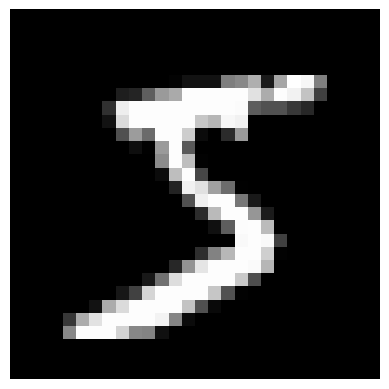

In [ ]:
index = 0
# From 0 to 59.999
image = train_set[index][0]
image = image.transpose(0, 1).transpose(1, 2)
plt.axis("off")
plt.imshow(image, cmap="gray")

## Step 1: Creating Patches

To create the patches we need to pick a value for the $p$ parameter. This process
will create $m$ patches, where $$ m = \frac{hw}{p^2} $$

Our dataset has a size of $(60.000, 1, 28, 28)$. We will use $p=4$, and the number
of patches will be $m=49$.

The size dimensions of each patch are $p \times p$, in our case $4 \times 4$.
Each image will be broken down into a $\sqrt{m} \times \sqrt{m}$ grid, in our case
the grid will be $7 \times 7$.

After these transfromations, the dataset will have a size of $(60.000, 7, 7, 4, 4)$.
We need to flatten the dimensions of the grid and each patch into $(60.000, 49, 16)$.


<img src="https://github.com/jgenc/vit-research/blob/main/resources/Patches.png?raw=1" alt="Patches" width="500"/>

Το παρακάτω δείχνει πώς θα χωριστεί κάθε εικόνα στις ενημερώσεις κώδικα.

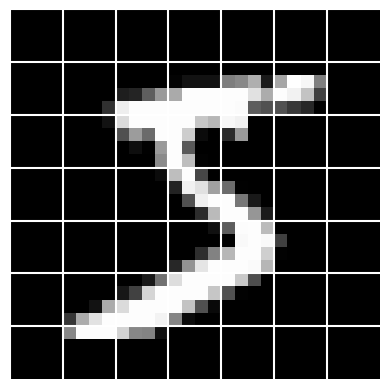

In [ ]:
show_patches(image)

In [ ]:
def patchify(images, n_patches):
    n, c, h, w = images.shape
    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.flatten(2, 3).flatten(3, 4).flatten(1, 2)
    return patches

## Step 2: Linear Embedding

Now we need to transform the patches into tokens, which is the same process as the
traditional [Transformer](https://arxiv.org/abs/1706.03762).

This step includes the tuning of the `hidden_d` parameter, which is a Hyper Parameter
of the model. In our simple training examples we will use a value of $8$.
There's also the `input_d` parameter, which is calculated with $p^2$. We chose
a value of $4$ for $p$, so `input_d` will have a value of $16$.

Βήμα 2: Γραμμική Ενσωμάτωση
Τώρα πρέπει να μετατρέψουμε τα τμήματα σε διακριτές ενότητες (tokens), το οποίο είναι το ίδιο βήμα με τον παραδοσιακό μετασχηματιστή (Transformer).

Αυτό το βήμα περιλαμβάνει την ρύθμιση της παραμέτρου hidden_d, η οποία είναι μια υπερπαράμετρος του μοντέλου. Στα απλά παραδείγματα εκπαίδευσης θα χρησιμοποιήσουμε μια τιμή 8. Υπάρχει επίσης η παράμετρος input_d, η οποία υπολογίζεται με το p². Επιλέξαμε μια τιμή 4 για το p, οπότε η input_d θα έχει μια τιμή

In [ ]:
class MyViT(torch.nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7):
        super(MyViT, self).__init__()

        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches

        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

    def forward(self, images):
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)
        return tokens

## Step 3: Classification token \<cls\>

It's a learnable parameter of the model. We will need to add it to the tokens
we created in the previous step.

This token's size is `(1, hidden_d)`. If we add this to the tokens we have already
made, we will have a size of $(60.000, 50, 16)$ for the input.

We update the `MyVit` class with the \<cls\> token.

Βήμα 3: Ενότητα Κατηγοριοποίησης <cls>
Είναι μια μάθιμη παράμετρος του μοντέλου. Θα πρέπει να την προσθέσουμε στα τμήματα που δημιουργήσαμε στο προηγούμενο βήμα.

Το μέγεθος αυτής της ενότητας είναι (1, hidden_d). Αν την προσθέσουμε στα τμήματα που έχουμε ήδη δημιουργήσει, θα έχουμε ένα μέγεθος (60.000, 50, 16) για την είσοδο.

Ενημερώνουμε την κλάση MyVit με την ενότητα <cls>.

In [ ]:
class MyViT(torch.nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7):
        super(MyViT, self).__init__()

        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches

        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)
        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classifiation token
        self.class_token = torch.nn.Parameter(torch.rand(1, self.hidden_d))

    def forward(self, images):
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.stack(
            [torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))]
        )

        return tokens

## Step 4: Positional Encoding

The model up until now does not save the positional information
of each patch in the original image. However, that information is crucial for any
image task, as we would not like to return an image with jumbled patches.

To solve this we will create the positional embeddings of each token using the
sin and cos functions.

The following function needs the `sequence_length` and `hidden_d` parameters.
`sequence_length` is the number of tokens created for each image (which is $50$)
and `hidden_d` is a hyperparameter we defined earlier (which is $8$)

Βήμα 4: Θέσιμο Κωδικοποίησης
Το μοντέλο μέχρι τώρα δεν διατηρεί τις θέσεις κάθε τμήματος στην αρχική εικόνα. Ωστόσο, αυτή η πληροφορία είναι κρίσιμη για οποιαδήποτε εργασία με εικόνες, καθώς δεν θα θέλαμε να επιστρέψουμε μια εικόνα με ανακατεμένα τμήματα.

Για να λύσουμε αυτό, θα δημιουργήσουμε τις θέσιμες ενσωματώσεις κάθε τμήματος χρησιμοποιώντας τις συναρτήσεις sin και cos.

Η ακόλουθη συνάρτηση χρειάζεται τις παραμέτρους sequence_length και hidden_d. Το sequence_length είναι το πλήθος των ενοτήτων που δημιουργήθηκαν για κάθε εικόνα (που είναι 50) και το hidden_d είναι μια υπερπαράμετρος που ορίσαμε προηγουμένως (που είναι 8).

In [ ]:
def get_positional_embeddings(sequence_length, hidden_d):
    result = torch.ones(sequence_length, hidden_d)

    for i in range(sequence_length):
        for j in range(hidden_d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / hidden_d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / hidden_d)))
            )
    return result

The following cell plots the positional embeddings using the values of our model.

Το ακόλουθο κελί σχεδιάζει τις θέσιμες ενσωματώσεις χρησιμοποιώντας τις τιμές του μοντέλου μας.

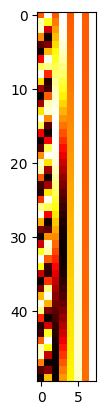

In [ ]:
plt.imshow(get_positional_embeddings(49 + 1, 8), cmap="hot", interpolation="nearest")
plt.show()

We can increase the size of the parameters to see how the positional encodings
would look for bigger models.


Μπορούμε να αυξήσουμε το μέγεθος των παραμέτρων για να δούμε πώς θα φαίνονται οι θέσιμες κωδικοποιήσεις για μεγαλύτερα μοντέλα.

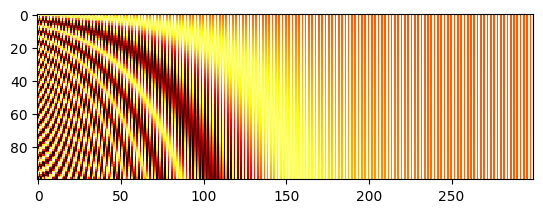

In [ ]:
plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
plt.show()

We update the `MyViT` class with the new functionality

Ενημερώνουμε την κλάση MyViT με τη νέα λειτουργικότητα.

In [ ]:
class MyViT(torch.nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7):
        super(MyViT, self).__init__()

        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches

        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classifiation token
        self.class_token = torch.nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.pos_embed = torch.nn.Parameter(
            torch.tensor(
                get_positional_embeddings(self.n_patches**2 + 1, self.hidden_d)
            )
        )
        self.pos_embed.requires_grad = False

    def forward(self, images):
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.stack(
            [torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))]
        )

        # Adding positional embedding
        pos_embed = self.pos_embed.repeat(n, 1, 1)

        out = tokens + pos_embed
        return out

## Step 5: Encoder Module

In this step we will impelement the following:

- Multi-Head Self-Attention (MSA)
- Multi-Layer Perceptron (MLP)

Before we apply each of these blocks we will create residual connetions and
pass the input through a Layer Normalisation layer.

Βήμα 5: Ενότητα Κωδικοποιητή
Σε αυτό το βήμα θα υλοποιήσουμε τα παρακάτω:

Πολυκεφαλική Αυτο-Προσοχή (MSA)
Πολυεπίπεδο Πασιφανή Νευρωνικό Δίκτυο (MLP)
Πριν εφαρμόσουμε κάθε ένα από αυτά τα μπλοκ, θα δημιουργήσουμε συνδέσεις υπολειτουργιών και θα περάσουμε την είσοδο μέσω ενός επιπέδου Κανονικοποίησης Στρώματος (Layer Normalisation).

In [ ]:
class MyMSA(torch.nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()

        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)

        self.q_mappings = torch.nn.ModuleList(
            [torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = torch.nn.ModuleList(
            [torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = torch.nn.ModuleList(
            [torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )

        self.d_head = d_head
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)

        result = []

        for sequence in sequences:
            seq_result = []

            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]

                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5))

                seq_result.append(attention @ v)

            result.append(torch.hstack(seq_result))

        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [ ]:
class MyViTBlock(torch.nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()

        self.hidden_d = hidden_d
        self.n_heads = n_heads
        self.norm1 = torch.nn.LayerNorm(hidden_d)

        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = torch.nn.LayerNorm(hidden_d)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_d, mlp_ratio * hidden_d),
            torch.nn.GELU(),
            torch.nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

We update the `MyVit` class with the Encoder block


Ενημερώνουμε την κλάση MyVit με το μπλοκ Κωδικοποιητή.

In [ ]:
class MyViT(torch.nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = torch.nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = torch.nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

    def forward(self, images):
        # Dividing images into patches

        n, c, h, w = images.shape

        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        return out

## Step 6: Classification

The task of this notebook is to correctly classify the hand-drawn numbers of
the MNIST dataset.

We have 10 possible classes, meaning the output of the model will need to output
10 propabilities. We achieve this by adding an MLP block at the end of the model,
with an output dimension of 10 and an input dimension of the previous layer.

With a different dataset, which contains a different number of classes, we will
need to update the output dimension accordingly.

Βήμα 6: Κατηγοριοποίηση
Η εργασία αυτού του notebook είναι η σωστή ταξινόμηση των χειροποίητων αριθμών του συνόλου δεδομένων MNIST.

Έχουμε 10 πιθανές κατηγορίες, που σημαίνει ότι η έξοδος του μοντέλου θα πρέπει να εξάγει 10 πιθανότητες. Επιτυγχάνουμε αυτό με το να προσθέσουμε ένα μπλοκ MLP στο τέλος του μοντέλου, με διάσταση εξόδου 10 και διάσταση εισόδου του προηγούμενου επιπέδου.

Με ένα διαφορετικό σύνολο δεδομένων, το οποίο περιέχει ένα διαφορετικό αριθμό κατηγοριών, θα πρέπει να ενημερώσουμε αντίστοιχα τη διάσταση εξόδου.

In [ ]:
class MyViT(torch.nn.Module):
    def __init__(self, chw, n_patches=7, num_layers=2, hidden_dim=8, num_heads=2, num_classes=10):
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = num_layers
        self.n_heads = num_heads
        self.hidden_d = hidden_dim

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = torch.nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_dim),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = torch.nn.ModuleList(
            [MyViTBlock(hidden_dim, num_heads) for _ in range(num_layers)]
        )

        # 5) Classification MLPk
        self.mlp = torch.nn.Sequential(torch.nn.Linear(self.hidden_d, num_classes), torch.nn.Softmax(dim=-1))

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output category distribution

## Training the Vision Transformer on MNIST

Your environment might have a GPU, TPU or the MPS chip made by Apple.
If the accelerator device actually exists it would be better to train the model
on that device rather than on the CPU.

Εκπαίδευση του Vision Transformer στο MNIST
Η περιβαλλοντική σας μπορεί να διαθέτει GPU, TPU ή το επεξεργαστικό μικροτσίπ από την Apple (MPS). Αν ο περιφερειακός επιταχυντής υπάρχει πράγματι, θα ήταν καλύτερο να εκπαιδεύσετε το μοντέλο σε αυτήν τη συσκευή αντί για τη CPU.

In [ ]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device {device}")

Using device cuda


We create an instance of the model with values of the parameters we used in the
previous cells.

We can experiment with different values for each parameter. Notably:
- `num_layers` indicates the number of encoder blocks containing the MSA and MLP blocks
- `hidden_d` is used to change the dimensionality of the hidden layers
- `num_heads` is the parameter which indicates how many parallel multiplications
will be computed on the Q, K, V matrices. In the Figure 2 at the start of the
model you can look at the $(c)$ part
- `num_classes` is the number that handles the output dimension size. As we said
before, this number depends on the task and the dataset used


Δημιουργούμε μια παράδειγμα του μοντέλου με τιμές των παραμέτρων που χρησιμοποιήθηκαν στα προηγούμενα κελιά.

Μπορούμε να πειραματιστούμε με διαφορετικές τιμές για κάθε παράμετρο. Ειδικότερα:

Το num_layers υποδεικνύει τον αριθμό των μπλοκ κωδικοποιητών που περιέχουν τα μπλοκ MSA και MLP.
Το hidden_d χρησιμοποιείται για να αλλάξει τη διαστασιμότητα των κρυφών επιπέδων.
Το num_heads είναι η παράμετρος που υποδεικνύει πόσοι παράλληλοι πολλαπλασιασμοί θα υπολογιστούν στις πινακίδες Q, K, V. Στο Σχήμα 2 στην αρχή του μοντέλου μπορείτε να δείτε το τμήμα (c).
Το num_classes είναι ο αριθμός που διαχειρίζεται το μέγεθος της διάστασης εξόδου. Όπως είπαμε προηγουμένως, αυτός ο αριθμός εξαρτάται από την εργασία και το σύνολο δεδομένων που χρησιμοποιείται.

In [ ]:
num_layers = 2
hidden_dim = 8
num_heads = 2
num_classes = 10

In [ ]:
model = MyViT(
    chw=(1, 28, 28),
    n_patches=7,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_classes=num_classes,
).to(device)

We need to pick a number of epochs and the Learing rate, just like every
Deep Learning project

Πρέπει να επιλέξουμε έναν αριθμό εποχών και το ρυθμό μάθησης, όπως σε κάθε έργο Deep Learning.

In [ ]:
N_EPOCHS = 5
LR = 5e-3

In [ ]:
train_loss_metric = []
train_accuracy_metric = []
test_loss_metric = []
test_accuracy_metric = []

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

for epoch in trange(N_EPOCHS, desc="Training"):
    correct, total = 0, 0
    train_loss = 0.0
    # Train
    for batch in tqdm(
        train_loader, desc=f"Epoch {epoch + 1} in training", leave=False, miniters=1
    ):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)
        # print(f"\n\nTrain Loss: {train_loss}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
        # print(f"[TRAIN] We have {correct} corrects and {total} total")

    print(
        f"Epoch {epoch + 1}/{N_EPOCHS} \nTrain loss: {train_loss:.2f}, Train accuracy: {correct / total * 100:.2f}%"
    )

    train_loss_metric.append(train_loss)
    train_accuracy_metric.append(correct / total * 100)

    # Test
    with torch.no_grad():
        correct_test, total_test = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            test_loss += loss.detach().cpu().item() / len(test_loader)
            correct_test += (
                torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            )
            total_test += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct_test / total_test * 100:.2f}%")
        # print(f"[TEST] We have {correct_test} corrects and {total_test} total")
    test_loss_metric.append(test_loss)
    test_accuracy_metric.append(correct_test / total_test * 100)

save_metrics(
    num_layers,
    num_heads,
    hidden_dim,
    30,
    N_EPOCHS,
    LR,
    train_accuracy_metric,
    test_accuracy_metric,
    train_loss_metric,
    test_loss_metric
)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5 
Train loss: 2.10, Train accuracy: 34.84%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 1.96
Test accuracy: 50.49%


Epoch 2 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5 
Train loss: 1.90, Train accuracy: 55.64%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 1.87
Test accuracy: 59.21%


Epoch 3 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5 
Train loss: 1.80, Train accuracy: 65.88%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 1.76
Test accuracy: 70.30%


Epoch 4 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5 
Train loss: 1.76, Train accuracy: 69.75%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 1.74
Test accuracy: 71.78%


Epoch 5 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5 
Train loss: 1.75, Train accuracy: 71.27%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 1.73
Test accuracy: 72.67%


We need to look at the performance of the model as the epochs go on, so that we can
see if the model is actually learning. We will plot the Accuracy and Loss curves.

For the following cell to work the previous cell has to have finished, which can
take a while depending on what device the model is trained on.

Each training run will save the output in the `metrics` local folder. If you
want to plot specific run results than uncomment the `show_metrics` line and
change the parameter to the run you want to plot.


Πρέπει να εξετάσουμε την απόδοση του μοντέλου καθώς οι εποχές προχωρούν, ώστε να δούμε εάν το μοντέλο πραγματικά μαθαίνει. Θα σχεδιάσουμε τις καμπύλες Ακρίβειας και Απώλειας.

Για να λειτουργήσει το ακόλουθο κελί, το προηγούμενο κελί πρέπει να έχει ολοκληρωθεί, το οποίο μπορεί να διαρκέσει αρκετή ώρα ανάλογα με τη συσκευή στην οποία εκπαιδεύεται το μοντέλο.

Κάθε εκπαίδευση θα αποθηκεύει τα αποτελέσματα στον τοπικό φάκελο metrics. Αν θέλετε να σχεδιάσετε συγκεκριμένα αποτελέσματα εκτέλεσης, τότε ξεσχολιάστε τη γραμμή show_metrics και αλλάξτε την παράμετρο σε την εκτέλεση που θέλετε να σχεδιάσετε.

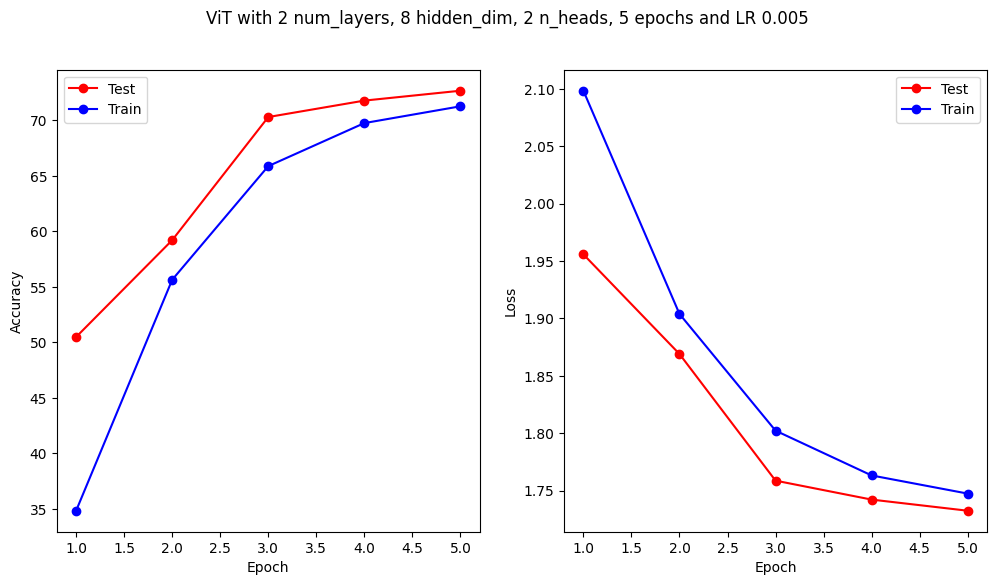

In [ ]:
plot_results(
    num_layers,
    num_heads,
    hidden_dim,
    N_EPOCHS,
    LR,
    test_accuracy_metric,
    train_accuracy_metric,
    test_loss_metric,
    train_loss_metric,
)

# show_metrics("./metrics/23-12-07_21-15-28_metrics.npz")

Notice that the model we trained performs better on the test set rather than
on the train set. This is not normal behaviour. Our implementation of the Vision
Transformer does not implement standard techniques of machine learning, such as
Dropout.

In the following cells we will try out PyTorch's implementation of ViT.

We can see that the model's accuracy and loss is not very stable. Also, the
training time was significantly less than our previous implementation (this allows
us to try and train the model with bigger hyperparameters)

We will train the model for more epochs and we will modify model's parameters.


Παρατηρήστε ότι το μοντέλο που εκπαιδεύσαμε παρουσιάζει καλύτερη απόδοση στο σύνολο δεδομένων ελέγχου από ό,τι στο σύνολο δεδομένων εκπαίδευσης. Αυτή δεν είναι μια φυσιολογική συμπεριφορά. Η υλοποίησή μας του Vision Transformer δεν υλοποιεί τεχνικές τυπικών μεθόδων μηχανικής μάθησης, όπως η Dropout.

Στα επόμενα κελιά θα δοκιμάσουμε την υλοποίηση του ViT της PyTorch.

Παρατηρούμε ότι η ακρίβεια και η απώλεια του μοντέλου δεν είναι πολύ σταθερές. Επίσης, ο χρόνος εκπαίδευσης ήταν σημαντικά μικρότερος από την προηγούμενη υλοποίηση μας (αυτό μας επιτρέπει να δοκιμάσουμε και να εκπαιδεύσουμε το μοντέλο με μεγαλύτερες υπερπαραμέτρους).

Θα εκπαιδεύσουμε το μοντέλο για περισσότερες εποχές και θα τροποποιήσουμε τις παραμέτρους του μοντέλου.

In [ ]:
num_layers = 2
hidden_dim = 8
num_heads = 2
num_classes = 10

mlp_dim = 30
dropout = 0.1

N_EPOCHS = 5
LR = 5e-3

patch_size = 4     # This is the p parameter we used earlier
image_size = 28    # MNIST image size is 28x28

Grayscale images won't work on PyTorch's Vision Transformer, because the size of the images
are $(N, 1, 28, 28)$. The model needs input images of 3 dimensions. We need to transform
the dataset into the following size:
$$
(N, 3, 28, 28)
$$

To achieve this, we need to modify the dataset and add one more transformation, in addition
to the `toTensor()` one.

`Grayscale` transforms an image to graysclale, with an output channel size from 1 to 3.

In [ ]:
from torchvision.transforms import Grayscale, Compose

transforms = Compose([
    Grayscale(3),
    ToTensor(),
])

train_set = MNIST(root='./data', train=True, download=True, transform=transforms)
test_set = MNIST(root='./data', train=False, download=True, transform=transforms)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_layers=num_layers,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
    mlp_dim=mlp_dim,
    num_classes=num_classes,
    dropout=dropout,
).to(device)

# Default Parameters
# model = VisionTransformer().to(device)

In [ ]:
train_loss_metric = []
train_accuracy_metric = []
test_loss_metric = []
test_accuracy_metric = []

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

for epoch in trange(N_EPOCHS, desc="Training"):
    correct, total = 0, 0
    train_loss = 0.0
    # Train
    for batch in tqdm(
        train_loader, desc=f"Epoch {epoch + 1} in training", leave=False, miniters=1
    ):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)
        # print(f"\n\nTrain Loss: {train_loss}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
        # print(f"[TRAIN] We have {correct} corrects and {total} total")

    print(
        f"Epoch {epoch + 1}/{N_EPOCHS} \nTrain loss: {train_loss:.2f}, Train accuracy: {correct / total * 100:.2f}%"
    )

    train_loss_metric.append(train_loss)
    train_accuracy_metric.append(correct / total * 100)

    # Test
    with torch.no_grad():
        correct_test, total_test = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            test_loss += loss.detach().cpu().item() / len(test_loader)
            correct_test += (
                torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            )
            total_test += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct_test / total_test * 100:.2f}%")
        # print(f"[TEST] We have {correct_test} corrects and {total_test} total")
    test_loss_metric.append(test_loss)
    test_accuracy_metric.append(correct_test / total_test * 100)

save_metrics(
    num_layers,
    num_heads,
    hidden_dim,
    mlp_dim,
    N_EPOCHS,
    LR,
    train_accuracy_metric,
    test_accuracy_metric,
    train_loss_metric,
    test_loss_metric
)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5 
Train loss: 1.48, Train accuracy: 44.96%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 1.21
Test accuracy: 55.79%


Epoch 2 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5 
Train loss: 1.00, Train accuracy: 65.04%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 0.87
Test accuracy: 70.89%


Epoch 3 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5 
Train loss: 0.83, Train accuracy: 72.22%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 0.80
Test accuracy: 73.42%


Epoch 4 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5 
Train loss: 0.77, Train accuracy: 74.53%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 0.74
Test accuracy: 75.66%


Epoch 5 in training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5 
Train loss: 0.73, Train accuracy: 75.69%


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test loss: 0.70
Test accuracy: 76.84%


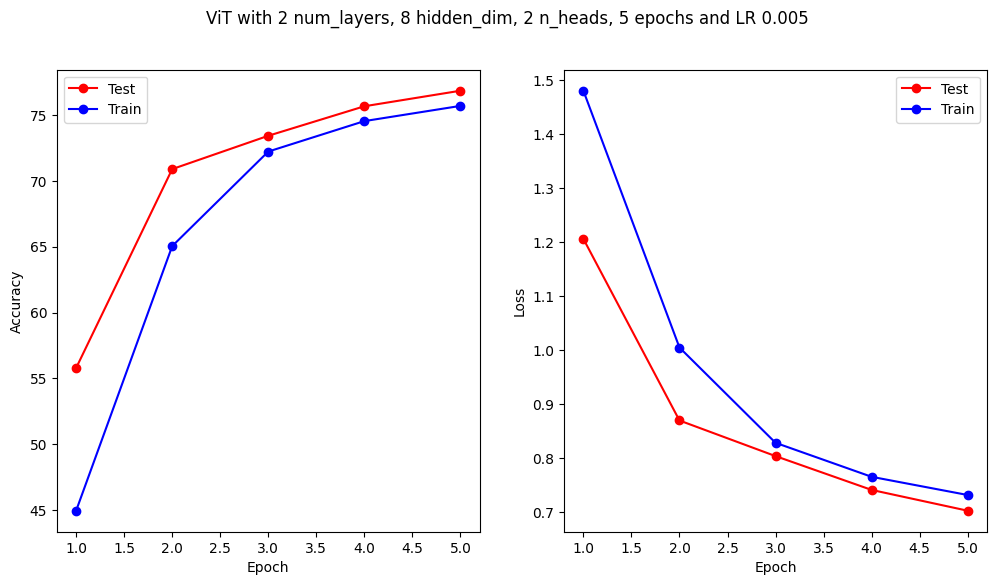

In [ ]:
plot_results(
    num_layers,
    num_heads,
    hidden_dim,
    N_EPOCHS,
    LR,
    test_accuracy_metric,
    train_accuracy_metric,
    test_loss_metric,
    train_loss_metric,
)

We can see that the model's accuracy and loss is not very stable. Also, the
training time was significantly less than our previous implementation (this allows
us to try and train the model with bigger hyperparameters)

We will train the model for more epochs and we will modify model's parameters.

Παρατηρούμε ότι η ακρίβεια και η απώλεια του μοντέλου δεν είναι πολύ σταθερές. Επίσης, ο χρόνος εκπαίδευσης ήταν σημαντικά μικρότερος από την προηγούμενη υλοποίησή μας (αυτό μας επιτρέπει να δοκιμάσουμε να εκπαιδεύσουμε το μοντέλο με μεγαλύτερες υπερπαραμέτρους).

Θα εκπαιδεύσουμε το μοντέλο για περισσότερες εποχές και θα τροποποιήσουμε τις παραμέτρους του μοντέλου.

In [ ]:
num_layers = 6
hidden_dim = 30
num_heads = 6
mlp_dim = 40
dropout = 0.1
num_classes = 10

patch_size = 4
image_size = 28

N_EPOCHS = 20
LR = 5e-3

model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_layers=num_layers,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
    mlp_dim=mlp_dim,
    num_classes=num_classes,
    dropout=dropout,
).to(device)

In [ ]:
metrics = train_loop(
    model,
    train_loader,
    test_loader,
    device,
    num_layers,

    num_heads,
    hidden_dim,
    mlp_dim,
    N_EPOCHS,
    LR,
)

train_loss_metric, train_accuracy_metric, test_loss_metric, test_accuracy_metric = metrics

Epoch 1 in training: 100%|█████████▉| 468/469 [00:26<00:00, 19.58it/s]
                                                                      

Epoch 1/20 
Train loss: 0.85, Train accuracy: 71.17%



Training:   5%|▌         | 1/20 [00:29<09:26, 29.82s/it]

Test loss: 0.44
Test accuracy: 85.91%



Epoch 2 in training: 100%|█████████▉| 468/469 [00:26<00:00, 18.89it/s]
                                                                      

Epoch 2/20 
Train loss: 0.37, Train accuracy: 88.21%



Training:  10%|█         | 2/20 [00:59<08:56, 29.79s/it]

Test loss: 0.28
Test accuracy: 90.97%



Epoch 3 in training: 100%|█████████▉| 468/469 [00:27<00:00, 20.08it/s]
                                                                      

Epoch 3/20 
Train loss: 0.29, Train accuracy: 90.88%



Training:  15%|█▌        | 3/20 [01:30<08:36, 30.40s/it]

Test loss: 0.25
Test accuracy: 92.43%



Epoch 4 in training: 100%|██████████| 469/469 [00:26<00:00, 16.10it/s]
                                                                      

Epoch 4/20 
Train loss: 0.25, Train accuracy: 92.20%



Training:  20%|██        | 4/20 [02:01<08:08, 30.55s/it]

Test loss: 0.24
Test accuracy: 92.57%



Epoch 5 in training: 100%|█████████▉| 467/469 [00:27<00:00, 18.50it/s]
                                                                      

Epoch 5/20 
Train loss: 0.22, Train accuracy: 93.07%



Training:  25%|██▌       | 5/20 [02:32<07:39, 30.64s/it]

Test loss: 0.18
Test accuracy: 94.16%



Epoch 6 in training: 100%|█████████▉| 467/469 [00:27<00:00, 19.36it/s]
                                                                      

Epoch 6/20 
Train loss: 0.20, Train accuracy: 93.95%



Training:  30%|███       | 6/20 [03:03<07:12, 30.90s/it]

Test loss: 0.18
Test accuracy: 94.57%



Epoch 7 in training: 100%|█████████▉| 467/469 [00:27<00:00, 19.01it/s]
                                                                      

Epoch 7/20 
Train loss: 0.18, Train accuracy: 94.19%



Training:  35%|███▌      | 7/20 [03:34<06:43, 31.02s/it]

Test loss: 0.19
Test accuracy: 94.00%



Epoch 8 in training: 100%|█████████▉| 468/469 [00:28<00:00, 17.95it/s]
                                                                      

Epoch 8/20 
Train loss: 0.17, Train accuracy: 94.60%



Training:  40%|████      | 8/20 [04:07<06:17, 31.47s/it]

Test loss: 0.16
Test accuracy: 94.86%



Epoch 9 in training: 100%|██████████| 469/469 [00:30<00:00, 11.22it/s]
                                                                      

Epoch 9/20 
Train loss: 0.16, Train accuracy: 94.91%



Training:  45%|████▌     | 9/20 [04:42<05:58, 32.56s/it]

Test loss: 0.14
Test accuracy: 95.55%



Epoch 10 in training: 100%|██████████| 469/469 [00:28<00:00, 17.72it/s]
                                                                       

Epoch 10/20 
Train loss: 0.15, Train accuracy: 95.15%



Training:  50%|█████     | 10/20 [05:14<05:24, 32.42s/it]

Test loss: 0.15
Test accuracy: 95.40%



Epoch 11 in training: 100%|██████████| 469/469 [00:28<00:00, 18.32it/s]
                                                                       

Epoch 11/20 
Train loss: 0.15, Train accuracy: 95.38%



Training:  55%|█████▌    | 11/20 [05:47<04:52, 32.55s/it]

Test loss: 0.15
Test accuracy: 95.21%



Epoch 12 in training: 100%|█████████▉| 467/469 [00:28<00:00, 18.44it/s]
                                                                       

Epoch 12/20 
Train loss: 0.14, Train accuracy: 95.53%



Training:  60%|██████    | 12/20 [06:19<04:18, 32.36s/it]

Test loss: 0.15
Test accuracy: 95.48%



Epoch 13 in training: 100%|█████████▉| 468/469 [00:30<00:00, 18.58it/s]
                                                                       

Epoch 13/20 
Train loss: 0.13, Train accuracy: 95.74%



Training:  65%|██████▌   | 13/20 [06:52<03:49, 32.78s/it]

Test loss: 0.15
Test accuracy: 95.14%



Epoch 14 in training: 100%|█████████▉| 468/469 [00:29<00:00, 15.32it/s]
                                                                       

Epoch 14/20 
Train loss: 0.13, Train accuracy: 96.04%



Training:  70%|███████   | 14/20 [07:25<03:16, 32.77s/it]

Test loss: 0.13
Test accuracy: 95.66%



Epoch 15 in training: 100%|██████████| 469/469 [00:29<00:00, 17.75it/s]
                                                                       

Epoch 15/20 
Train loss: 0.12, Train accuracy: 96.04%



Training:  75%|███████▌  | 15/20 [07:58<02:43, 32.79s/it]

Test loss: 0.12
Test accuracy: 96.07%



Epoch 16 in training: 100%|█████████▉| 468/469 [00:29<00:00, 18.35it/s]
                                                                       

Epoch 16/20 
Train loss: 0.12, Train accuracy: 96.20%



Training:  80%|████████  | 16/20 [08:32<02:12, 33.09s/it]

Test loss: 0.14
Test accuracy: 95.91%



Epoch 17 in training: 100%|██████████| 469/469 [00:31<00:00, 12.99it/s]
                                                                       

Epoch 17/20 
Train loss: 0.12, Train accuracy: 96.36%



Training:  85%|████████▌ | 17/20 [09:08<01:41, 33.94s/it]

Test loss: 0.12
Test accuracy: 96.34%



Epoch 18 in training: 100%|██████████| 469/469 [00:29<00:00, 18.49it/s]
                                                                       

Epoch 18/20 
Train loss: 0.11, Train accuracy: 96.44%



Training:  90%|█████████ | 18/20 [09:42<01:07, 33.96s/it]

Test loss: 0.12
Test accuracy: 96.35%



Epoch 19 in training: 100%|█████████▉| 468/469 [00:29<00:00, 17.57it/s]
                                                                       

Epoch 19/20 
Train loss: 0.11, Train accuracy: 96.47%



Training:  95%|█████████▌| 19/20 [10:15<00:33, 33.67s/it]

Test loss: 0.11
Test accuracy: 96.13%



Epoch 20 in training: 100%|██████████| 469/469 [00:30<00:00, 18.18it/s]
                                                                       

Epoch 20/20 
Train loss: 0.10, Train accuracy: 96.75%



Training: 100%|██████████| 20/20 [10:49<00:00, 32.48s/it]

Test loss: 0.12
Test accuracy: 96.30%


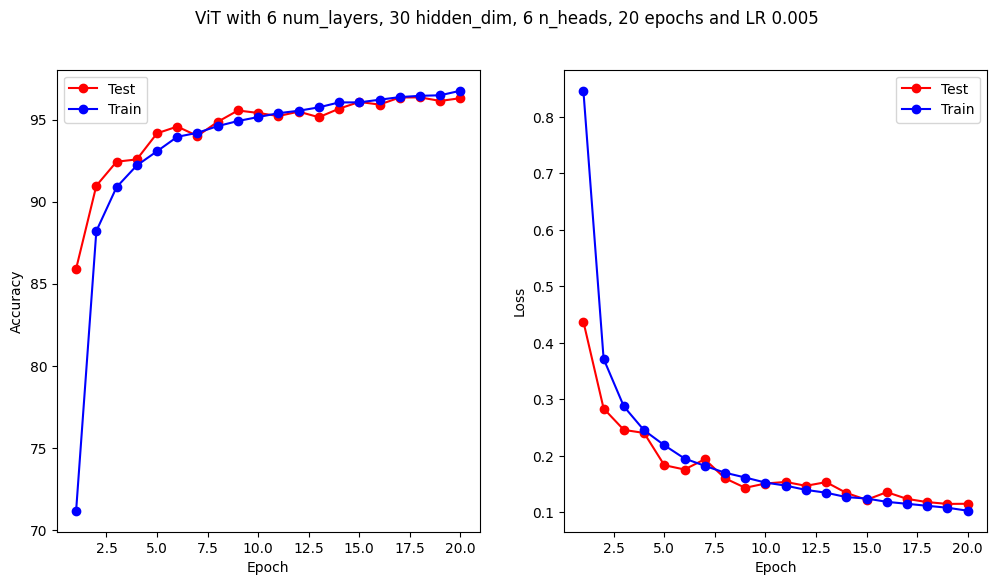

In [ ]:
plot_results(
    num_layers,
    num_heads,
    hidden_dim,
    N_EPOCHS,
    LR,
    test_accuracy_metric,
    train_accuracy_metric,
    test_loss_metric,
    train_loss_metric,
)

The model is now much more stable and approaches the 100% accuracy rate.

Let's try and see what the model predicts from a random image in the train dataset.
You can try and change the index to another image. Remember, there are 10.000 images
in that set.

Το μοντέλο είναι τώρα πολύ πιο σταθερό και πλησιάζει το ποσοστό ακρίβειας 100%.

Ας δοκιμάσουμε και να δούμε τι προβλέπει το μοντέλο από μια τυχαία εικόνα στο σύνολο δεδομένων εκπαίδευσης. Μπορείτε να δοκιμάσετε να αλλάξετε το δείκτη σε μια άλλη εικόνα. Θυμηθείτε, υπάρχουν 10.000 εικόνες σε αυτό το σύνολο.

Model predicted class 4


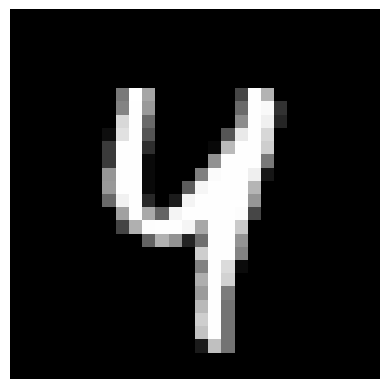

In [ ]:
index = 42
image, label = test_loader.dataset[index]

plt.axis("off")
plt.imshow(image.transpose(0, 2).transpose(0, 1), cmap="gray")

prediction = model(image.unsqueeze(0).to(device))
print(f"Model predicted class {torch.argmax(prediction).item()}")